In [1]:
# Important: I copied this file from graphpattern_class

import pandas as pd
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool
import networkx as nx
import csv
import inspect
import os

import json
import inspect

In [2]:
data_path = 'data/'

In [3]:
class Prepare(object): 
    
    __filter_by_cc = False
    
    def __init__(self, data_path, edge_file, merge_file, node_file, relation_file, store_data = True, process=0, GO_threshold = 400, reactome_hierarchy='ReactomePathwaysRelation.txt'):
        
        self.__data_path = data_path
        self.__edge_file = edge_file
        
        self.__merge_file = merge_file
        self.__node_file = node_file
        self.__relation_file = relation_file        
        
        self.__edge_col_names  = ['h','t','r'] 
        self.__merge_col_names = ['h','t','r', 'h_id', 't_id', 'r_id']
        self.__other_col_names = ['id', 'name']
        self.__merge_col_id =    ['h_id', 't_id', 'r_id']
        
        self.__store_data = store_data
        
        if process == 0:
            self.__read_edge_file()
            self.__assign_ids()    
            self.__merge_data()
            
        else:
            self.__read_processed_files()
            
        self.__check_connectivity(self.__df_merge)
        self.__stat_connected_components()
        
        if (len(self.__connected_components_g) > 1):
            self.__filter_only_connected_component(self.__df_merge, self.__df_nodes)
            
        self.check_merge_nodes(self.__df_merge, self.__df_nodes)
    
        self.__remove_highlevel_pathways('data/original/', reactome_hierarchy, names = ['parent', 'child'])
        self.__remove_high_frequent_GO_terms(GO_threshold)
        
        self.__check_connectivity(self.__df_merge_cc)
        self.__stat_connected_components()
        
        if (len(self.__connected_components_g) > 1):
            self.__filter_only_connected_component(self.__df_merge_cc, self.__df_nodes_cc)
        
            
    def __read_edge_file(self):
        ecols = self.__edge_col_names
        self.__df_edges = pd.read_csv(self.__data_path + self.__edge_file, names=ecols
                                      , dtype={ecols[0]:str, ecols[1]:str, ecols[2]:str})
        
        print('__read_edge_file| df_edges: {}'.format(self.__df_edges.shape))
        print() 
        
    def __merge_data(self):
        df = self.__df_edges
        cols = self.__edge_col_names
        
        print('__merge_data| merging first column ...')
        df_merge = df.merge(self.__df_nodes, how='left', left_on = cols[0], right_on = 'name')
        
        df_merge = df_merge.drop(columns=['name'])
        df_merge = df_merge.rename(columns={'id': cols[0]+'_id'})

        print('__merge_data| merging second column ...')
        df_merge = df_merge.merge(self.__df_nodes, how='left', left_on = cols[1], right_on = 'name')
        df_merge = df_merge.drop(columns=['name'])
        df_merge = df_merge.rename(columns={'id': cols[1]+'_id'})

        print('__merge_data| merging third column ...')
        df_merge = df_merge.merge(self.__df_relations, how='left', left_on = cols[2], right_on = 'name')
        df_merge = df_merge.drop(columns=['name'])
        df_merge = df_merge.rename(columns={'id': cols[2]+'_id'})
        
        print('__merge_data| merging Done.')
        self.__df_merge = df_merge
        
        if self.__store_data == True:
            self.__df_merge.to_csv(self.__data_path + self.__merge_file + '.csv', index=False)
            print('__merge_data| df_merge was saved.')
        print()
        
    def __assign_ids_to_nodes(self, df, cols):

        list_h = list(df[cols[0]].unique())        
        list_t = list(df[cols[1]].unique())
        list_ht = list(set(list_h+list_t))
        print('__assign_ids_to_nodes| head nodes: {}, tail nodes: {}, combined: {}'.format( len(list_h), len(list_t), len(list_ht)))
        
        df_nodes = pd.DataFrame(list_ht)
        df_nodes = df_nodes.rename(columns = {0:'name'})
        df_nodes = df_nodes.assign(id = df_nodes.index)
        self.__df_nodes = df_nodes[['id', 'name']]
        print('__assign_ids_to_nodes| df_nodes: {} was created.'.format( df_nodes.shape ))
        
        if self.__store_data == True:
            self.__df_nodes.to_csv(self.__data_path + self.__node_file + '.csv', index=False)
            print('__assign_ids_to_nodes| df_nodes was saved.')
        print()  

    def __assign_ids_to_relations(self, df, cols):
        
        list_r = list(df[cols[2]].unique())
        df_relations = pd.DataFrame(list_r)
        df_relations = df_relations.rename(columns = {0:'name'})
        df_relations = df_relations.assign(id = df_relations.index)
        self.__df_relations = df_relations[['id', 'name']]
        print('__assign_ids_to_relations| df_relations: {} was created.'.format( df_relations.shape ))
        
        if self.__store_data == True:
            self.__df_relations.to_csv(self.__data_path + self.__relation_file + '.csv', index=False)
            print('__assign_ids_to_relations| df_relation was saved.')
        print()            
        
    
    def __assign_ids(self):
        df = self.__df_edges
        cols = self.__edge_col_names    
        self.__assign_ids_to_nodes(df, cols)
        self.__assign_ids_to_relations(df, cols)
        
    def __read_processed_files(self):
        mcols = self.__merge_col_names
        
        self.__df_merge = pd.read_csv(self.__data_path + self.__merge_file + '.csv'
                                      , dtype={mcols[0]: object, mcols[1]: object, mcols[2]:object, mcols[3]:int
                     
                                               , mcols[4]:int, mcols[5]:int})
        print('__read_processed_files| df_merge: {}'.format(self.__df_merge.shape))
        
        self.__df_nodes = pd.read_csv(self.__data_path + self.__node_file + '.csv')
        print('__read_processed_files| df_nodes: {}'.format(self.__df_nodes.shape))
        
        self.__df_relations = pd.read_csv(self.__data_path + self.__relation_file + '.csv')
        print('__read_processed_files| df_relations: {}'.format(self.__df_relations.shape))
        
        print()  

    def __check_connectivity(self, df):

        print('__check_connectivity| df : {}'.format(df.shape))
        df_edges = df[self.__merge_col_id]
        edges = [tuple(x) for x in df_edges.values]
        print('__check_connectivity| edges: {}'.format(len(edges)))

        GRAPH = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
        GRAPH.add_weighted_edges_from(edges)
        connected_components_list_len = [len(c) for c in sorted(nx.connected_components(GRAPH), key=len, reverse=True)]
        print('__check_connectivity| number of connected components: {}'.format(len(connected_components_list_len)))
        cc_g = list( nx.connected_components(GRAPH) )
        total_from_cc = np.sum(connected_components_list_len) # IT WAS OKAY
        print('__check_connectivity| number of total node in data based on the Networkx\'s Graph {}'.format(total_from_cc) )
        self.__connected_components_g = cc_g
        self.__connected_components_list_len = connected_components_list_len
        print()
    
    def __stat_connected_components(self):
        cc_list_len = self.__connected_components_list_len
        largest_cc_len = cc_list_len[0]
        rest_cc_len = np.sum(cc_list_len[1:])
        total_cc_len = np.sum(cc_list_len)
        print('__stat_connected_components| total nodes: {}, largest components #: {}, the rest nodes: {}'
              .format(total_cc_len, largest_cc_len, rest_cc_len)) 
        print()
        
    def __filter_only_connected_component(self,df_m, df_n):
        cc_g = self.__connected_components_g
        mcols = self.__merge_col_names
        ncols = self.__other_col_names
        
        list_ids_main_cc = list(cc_g[0])
        list_ids_main_cc.sort()
        print('__filter_only_connected_component| list_ids_main_cc: {}'.format(len(list_ids_main_cc)))

        df_nodes_cc = df_n[df_n[ncols[0]].isin(list_ids_main_cc) ]
        print('__filter_only_connected_component| df_nodes_cc: {}'.format(df_nodes_cc.shape))

        df_merge_cc = df_m[(df_m[mcols[3]].isin(list_ids_main_cc)) | (df_m[mcols[4]].isin(list_ids_main_cc))]
        print('__filter_only_connected_component| df_merge_cc: {}'.format(df_merge_cc.shape))        
        
        merge_shape = df_m.shape
        merge_cc_shape = df_merge_cc.shape
        print('__filter_only_connected_component| edges removed: {}'.format(merge_shape[0] - merge_cc_shape[0]))  
        
        self.__filter_by_cc = True    
        
        cc_rest = list(cc_g)[1:]
        
#         df_n.set_index(ncols[0], inplace=True)
#         list_cc_rest = [ df_n.loc[i,'name'] for s in cc_rest for i in s  ]
#         df_n.reset_index(inplace=True)
        list_cc_rest = [i for s in cc_rest for i in s ]
        
        self.__list_cc_rest = list_cc_rest
        print('__filter_only_connected_component| The list of nodes {}, that has been removed was collected.'.format(len(self.__list_cc_rest)))
        
        df_removed_edges = self.__retrieve_edges_by_nodes_from_merge(list_cc_rest)
        print('__filter_only_connected_component| df_removed_edges: {}'.format(df_removed_edges.shape))
        
        df_removed_relation_freq = df_removed_edges.groupby(mcols[2])[mcols[0]].count().reset_index(name='count')
        self.__df_removed_relation_freq = df_removed_relation_freq
        print('__filter_only_connected_component| The frequency of relations that has been removed was collected.')
        
        self.__df_merge_cc = df_merge_cc
        self.__df_nodes_cc = df_nodes_cc 
        
        self.__df_merge_cc.to_csv(self.__data_path + self.__merge_file + '_cc.csv', index=False)
        print('__filter_only_connected_component| df_merge_cc was saved.')
        
        self.__df_nodes_cc.to_csv(self.__data_path + self.__node_file + '_cc.csv', index=False)
        print('__filter_only_connected_component| df_nodes_cc was saved.')
    
        cc_rest_len = self.__connected_components_list_len[1:]
        min_len = np.min(cc_rest_len)
        max_len = np.max(cc_rest_len)
        
        self.__hist_array(cc_rest_len, "histogram of component removed.", bins=np.arange(min_len,max_len+1,1))
        
        print()
        
    def __load_human_kinase_list(self, light_file, dark_file):
        self.__df_light = pd.read_csv(self.__data_path + light_file)
        print('__load_human_kinase_list| df_light: {}'.format(self.__df_light.shape))
        self.__df_dark  = pd.read_csv(self.__data_path + dark_file)
        print('__load_human_kinase_list| df_dark: {}'.format(self.__df_dark.shape))
        
    
    def check_missing_human_kinase(self, light_file, dark_file, original = True):
        mcols = self.__merge_col_names
        ncols = self.__other_col_names
        
        self.__load_human_kinase_list(light_file, dark_file)
        
        df = self.__df_merge
        
        list_s_df = list(df[mcols[0]].unique())
        
        list_human_light = list(self.__df_light['uniprot'])
        missing_from_light_list = [i for i in list_human_light if i not in list_s_df]
        print('check_missing_human_kinase| missing # of light kinase nodes: {}'.format(missing_from_light_list))
        print('check_missing_human_kinase| missing # of edges of light kinase: {}'.format(df[df[mcols[0]].isin(missing_from_light_list)].shape))
        
        list_human_dark = list(self.__df_dark['uniprot'])
        missing_from_dark_list = [i for i in list_human_dark if i not in list_s_df]
        print('check_missing_human_kinase| missing # of dark kinase nodes: {}'.format(missing_from_dark_list))
        print('check_missing_human_kinase| missing # of edges of light kinase: {}'.format(df[df[mcols[0]].isin(missing_from_dark_list)].shape))
        
        print()
        
    def __hist_array(self, a, title, bins='auto'):

        print('__hist_array| min: {}, max: {}'.format(np.min(a), np.max(a)))
        _ = plt.hist(a, bins=bins)  # arguments are passed to np.histogram
        plt.title(title)

        plt.show()
        
    def __retrieve_edges_by_nodes_from_merge(self, lst, cc = True):
        mcols = self.__merge_col_names
        df = self.__df_merge
        df_selected = df[(df[mcols[3]].isin(lst)) | (df[mcols[4]].isin(lst))]
        
        return df_selected
    
    def __load_pathway_hierarchy(self, original_path, filename, names):
        
        self.__df_pathway_heirarchy = pd.read_csv(original_path + filename, sep='\t', names=names)
        print('__load_pathway_hierarchy| df_pathway_heirarchy: {}'.format(self.__df_pathway_heirarchy.shape))
    
    def __remove_highlevel_pathways(self, original_path, filename, names):
        hcols = names
        mcols = self.__merge_col_names
        ncols = self.__other_col_names
        self.__load_pathway_hierarchy(original_path, filename, names)
        df_h = self.__df_pathway_heirarchy
        
        set_0 = set(df_h[hcols[0]].unique())
        set_1 = set(df_h[hcols[1]].unique())
        
        print('__remove_highlevel_pathways| set_0: {}, set_1: {}'.format(len(set_0), len(set_1)))
        only_parent = [ i for i in list(set_0) if i not in list(set_1)]
        print('__remove_highlevel_pathways| Only parent: {}'.format(len(only_parent)))

        set_all =set( list(set_0) + list(set_1) )
        print('__remove_highlevel_pathways| set_all: {}'.format(len(set_all)))
        
        H = dict()
        for i in df_h.itertuples():
            p = i[1]
            c = i[2]
            if p not in H:
                H[p] = set()
            H[p].add(c)
            if c not in H:
                H[c] = set()
        print('__remove_highlevel_pathways| dict H: {}'.format(len(H)))
        
        list_to_remove = list()

        for p in only_parent:
            list_to_remove.append(p)
            for c in H[p]:
                list_to_remove.append(c)
                for cc in H[c]:
                    list_to_remove.append(cc)
                    

        print('__remove_highlevel_pathways| list_to_remove: {}'.format(len(list_to_remove)))

        list_to_remove_short = [i[i.rindex('-')+1:] for i in list_to_remove]
        
        df_nodes_cc_hl = self.__df_nodes_cc[~self.__df_nodes_cc[ncols[1]].isin(list_to_remove_short) ]
        print('__remove_highlevel_pathways| df_nodes_cc_hl: {}'.format(df_nodes_cc_hl.shape))

        df_merge_cc_hl = self.__df_merge_cc[~self.__df_merge_cc[mcols[1]].isin(list_to_remove_short)]
        print('__remove_highlevel_pathways| df_merge_cc_hl: {}'.format(df_merge_cc_hl.shape))        
        
        
        self.__list_to_remove_short = list_to_remove_short
        
        self.__df_merge_cc = df_merge_cc_hl
        self.__df_nodes_cc = df_nodes_cc_hl
        
        self.check_merge_nodes(self.__df_merge_cc, self.__df_nodes_cc)
        
        self.__df_merge_cc.to_csv(self.__data_path + self.__merge_file + '_cc.csv', index=False)
        print('__remove_highlevel_pathways| df_merge_cc_hl was saved.')
        
        self.__df_nodes_cc.to_csv(self.__data_path + self.__node_file + '_cc.csv', index=False)
        print('__remove_highlevel_pathways| df_nodes_cc_hl was saved.')
        print()
        
    def __filter_edges_by_relation(self, relations):
        df_m      = self.__df_merge_cc
        df_select = df_m[df_m['r'].isin(relations)]
        df_rest   = df_m[~df_m['r'].isin(relations)]
        print('__filter_edges_by_relation| df_select: {} , df_rest: {}'.format(df_select.shape, df_rest.shape))
        return df_select, df_rest
    
    def __remove_high_frequent_GO_terms(self, threshold):
        relations = ['hasBiologicalProcess','hasCellularComponent','hasMolecularFunction']
        df_GO, df_rest = self.__filter_edges_by_relation(relations)
        
        df_g = df_GO.groupby('t')['h'].count().reset_index(name = 'count')
        list_entities = np.array(df_g['t'])
        list_counts = np.array(df_g['count'])

        high_count_list = [list_entities[i] for i in range(len(list_entities)) if list_counts[i] > threshold]
        low_count_list  = [list_entities[i] for i in range(len(list_entities)) if list_counts[i] <= threshold]
        print('__remove_high_frequent_GO_terms| high: {}, low: {}, total: {}'.format(len(high_count_list), len(low_count_list),len(high_count_list) + len(low_count_list) ))
            
        edge_count = df_GO.shape[0]
        df_low = df_GO[df_GO['t'].isin(low_count_list)]
        edge_count_new = df_low.shape[0]
        diff = edge_count - edge_count_new
        print('__remove_high_frequent_GO_terms| from {} to {} : {} reduced.'.format(edge_count, edge_count_new, diff))
        
        df_merge_low = df_low.append(df_rest)
        self.__df_merge_cc = df_merge_low
        print('__remove_high_frequent_GO_terms| df_merge_cc: {}'.format(self.__df_merge_cc.shape))
        
        lst_h = list(self.__df_merge_cc['h'].unique())
        lst_t = list(self.__df_merge_cc['t'].unique())
        set_all =set(lst_h + lst_t)
        
        df_n = self.__df_nodes_cc[self.__df_nodes_cc['name'].isin(set_all)]
        print('__remove_high_frequent_GO_terms| df_nodes_cc: {}'.format(df_n.shape))
        
        self.__df_nodes_cc = df_n
        
        self.check_merge_nodes(self.__df_merge_cc, self.__df_nodes_cc)
        
        self.__df_merge_cc.to_csv(self.__data_path + self.__merge_file + '_cc.csv', index=False)
        print('__remove_high_frequent_GO_terms| df_merge_cc was saved.')
        
        self.__df_nodes_cc.to_csv(self.__data_path + self.__node_file + '_cc.csv', index=False)
        print('__remove_high_frequent_GO_terms| df_nodes_cc was saved.')
        
        print()
        
    def check_merge_nodes(self, df_m, df_n):
        lst_h = list(df_m['h'].unique())
        lst_t = list(df_m['t'].unique())
        set_all =set(lst_h + lst_t)

        df_n_sel = df_n[df_n['name'].isin(set_all)]

        set_n = set(df_n['name'].unique())

        c= 0
        for i in set_all:
            if i not in set_n:
                c+=1
        print('check_merge_nodes: {}'.format(c))

        
    def get__df_merge(self):
        return self.__df_merge
    
    def get__df_nodes(self):
        return self.__df_nodes
    
    def get__df_relations(self):
        return self.__df_relations
    
    def get__connected_components_g(self):
        return self.__connected_components_g
    
    def get__connected_components_list_len(self):
        return self.__connected_components_list_len
    
    def get__df_merge_cc(self):
        return self.__df_merge_cc
    
    def get__df_nodes_cc(self):
        return self.__df_nodes_cc
    
    def get__df_light(self):
        return self.__df_light
    
    def get__df_dark(self):
        return self.__df_dark
    
    def get__list_cc_rest(self):
        return self.__list_cc_rest
    
    def get__df_removed_relation_freq(self):
        return self.__df_removed_relation_freq
    
    def get__list_to_remove_short(self):
        return self.__list_to_remove_short

__read_edge_file| df_edges: (11067888, 3)

__assign_ids_to_nodes| head nodes: 182772, tail nodes: 57002, combined: 220471
__assign_ids_to_nodes| df_nodes: (220471, 2) was created.
__assign_ids_to_nodes| df_nodes was saved.

__assign_ids_to_relations| df_relations: (7, 2) was created.
__assign_ids_to_relations| df_relation was saved.

__merge_data| merging first column ...
__merge_data| merging second column ...
__merge_data| merging third column ...
__merge_data| merging Done.
__merge_data| df_merge was saved.

__check_connectivity| df : (11067888, 6)
__check_connectivity| edges: 11067888
__check_connectivity| number of connected components: 87
__check_connectivity| number of total node in data based on the Networkx's Graph 220471

__stat_connected_components| total nodes: 220471, largest components #: 220111, the rest nodes: 360

__filter_only_connected_component| list_ids_main_cc: 220111
__filter_only_connected_component| df_nodes_cc: (220111, 2)
__filter_only_connected_component| df

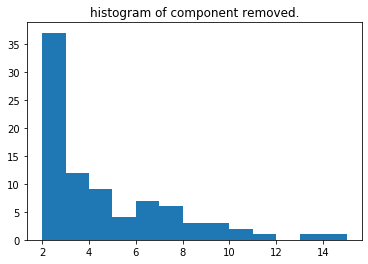


check_merge_nodes: 0
__load_pathway_hierarchy| df_pathway_heirarchy: (21490, 2)
__remove_highlevel_pathways| set_0: 7733, set_1: 20930
__remove_highlevel_pathways| Only parent: 388
__remove_highlevel_pathways| set_all: 21318
__remove_highlevel_pathways| dict H: 21318
__remove_highlevel_pathways| list_to_remove: 6948
__remove_highlevel_pathways| df_nodes_cc_hl: (219694, 2)
__remove_highlevel_pathways| df_merge_cc_hl: (10998264, 6)
check_merge_nodes: 0
__remove_highlevel_pathways| df_merge_cc_hl was saved.
__remove_highlevel_pathways| df_nodes_cc_hl was saved.

__filter_edges_by_relation| df_select: (9297948, 6) , df_rest: (1700316, 6)
__remove_high_frequent_GO_terms| high: 2644, low: 24586, total: 27230
__remove_high_frequent_GO_terms| from 9297948 to 1187588 : 8110360 reduced.
__remove_high_frequent_GO_terms| df_merge_cc: (2887904, 6)
__remove_high_frequent_GO_terms| df_nodes_cc: (213836, 2)
check_merge_nodes: 0
__remove_high_frequent_GO_terms| df_merge_cc was saved.
__remove_high_fre

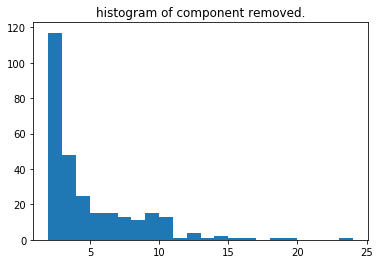

In [5]:
prepare = Prepare('data/', 'df_edges.csv', 'df_merge', 'df_nodes', 'df_relations', store_data = True, process=0)

In [6]:
# prepare2 = Prepare('data/', 'df_edges.csv', 'df_merge', 'df_nodes', 'df_relations', store_data = True, process=1)

In [7]:
# prepare2.check_missing_human_kinase('light_kinase.csv', 'dark_kinase.csv')
# prepare2.check_missing_human_kinase('light_kinase.csv', 'dark_kinase.csv', original = False)

In [8]:
class darkHasPathway(object):
    path = 'data/'
    df_m = pd.read_csv(path + 'df_merge_cc.csv')
    print('df_m: {}'.format(df_m.shape))
    
    df_hasPathway = df_m[df_m['r'] == 'hasPathway']
    print('df_hasPathway: {}'.format(df_hasPathway.shape))
    
    df_dark = pd.read_csv(path + 'dark_kinase.csv')
    print('df_dark: {}'.format(df_dark.shape))
    
    set_dark = set(df_dark['uniprot'].unique())
    print('set_dark: {}'.format(len(set_dark)))
    
    df_dark_hasPathway = df_hasPathway[df_hasPathway['h'].isin(set_dark)]
    print('df_dark_hasPathway: {}'.format(df_dark_hasPathway.shape))
    
    print(df_dark_hasPathway.head(5))
    
    df_dark_hasPathway.to_csv(path + 'df_dark_hasPathway.csv', index=False)
    print('df_dark_hasPathway is saved.')

df_m: (2886875, 6)
df_hasPathway: (170965, 6)
df_dark: (160, 3)
set_dark: 160
df_dark_hasPathway: (136, 6)
              h        t           r   h_id    t_id  r_id
1259831  O00750  1660499  hasPathway  16512  208000     0
1261133  O14730  6791226  hasPathway  85987   18997     0
1261396  O14986  1660499  hasPathway  15244  208000     0
1261397  O14986   201688  hasPathway  15244  155839     0
1261398  O14986  6811558  hasPathway  15244  204309     0
df_dark_hasPathway is saved.


In [ ]:
df_m = prepare.get__df_merge_cc()

In [ ]:
class CheckClasses(object):
    
    def __init__(self, df_merge):
        self.df_merge = df_merge
        print('__init__| df_merge: {}'.format(self.df_merge.shape))
        self.__analysis()
        
    def __analysis(self):
        df_m = self.df_merge.copy()
        df_g = df_m.groupby('r')['h'].count().reset_index(name = 'count')
        print(df_g)
        
    def filter_edges_by_relation(self, relations):
        df_m = self.df_merge
        df_select = df_m[df_m['r'].isin(relations)]
        print('select_edge_by_relation| By {} : {}'.format(relations, df_select.shape))
        return df_select
    

        
    def analysis_edge_by_relation(self, relations, threshold):
        
        df_select = self.filter_edges_by_relation(relations)
        
        df_g = df_select.groupby('t')['h'].count().reset_index(name = 'count')
        list_entities = np.array(df_g['t'])
        list_counts = np.array(df_g['count'])
        
        
        
        for th in threshold:
            print('analysis_edge_by_relation| Threshold: {}'.format(th))
            count_high = list_counts[list_counts > th]
            count_low = list_counts[list_counts <= th]
            print('analysis_edge_by_relation| high: {}, low: {}, total: {}'.format(len(count_high), len(count_low), len(count_high) + len(count_low)) )
            

            high_count_list = [list_entities[i] for i in range(len(list_entities)) if list_counts[i] > th]
            low_count_list  = [list_entities[i] for i in range(len(list_entities)) if list_counts[i] <= th]
            print('analysis_edge_by_relation| high: {}, low: {}, total: {}'.format(len(high_count_list), len(low_count_list),len(high_count_list) + len(low_count_list) ))
    
            edge_count = df_select.shape[0]
            df_low = df_select[df_select['t'].isin(low_count_list)]
            edge_count_new = df_low.shape[0]
            diff = edge_count - edge_count_new
            print('analysis_edge_by_relation| from {} to {} : {} reduced.'.format(edge_count, edge_count_new, diff))
            print()


In [ ]:
c = CheckClasses(df_m)   


In [ ]:
relation_list = ['interact']
df_ppi = c.filter_edges_by_relation(relation_list)

In [ ]:
relation_list = ['hasBiologicalProcess','hasCellularComponent','hasMolecularFunction']
threshold = [300, 400]
df_Go = c.analysis_edge_by_relation(relation_list, threshold)

In [ ]:
class EdgeR(object):
    
    def __init__(self, path, merge_file, out_path, out_file):
        
        self.merge_columns = ['h', 't', 'r', 'h_id', 't_id', 'r_id']
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            
    def make_two_column(self):
        mcols = self.merge_columns
        df_m = self.__read_files(self.merge_file)
        df_two_col = df_m[[mcols[3], mcols[4]]]
        print('df_two_col: {}'.format(df_two_col.shape))
        df_two_col.to_csv(self.out_path + self.out_file, index = False)
        print('df_two_col is saved.')
        
    def __read_files(self, filename, merge=False):
        if merge == True:
            df = pd.read_csv(self.path + filename, dtype={'t':str})
        else:    
            df = pd.read_csv(self.path + filename)
        print('read_files| read file {} with shape {}'.format(filename, df.shape))
        print()
        return df

In [ ]:
er = EdgeR('data/', 'df_merge_cc.csv', 'data/R-project/', 'df_review_noSplit.csv')

In [ ]:
df_sh = er.make_two_column()